## Optiver Competition (Version 6)

Notes:  

- I am still using the old features that I had found.
- I am going to create a couple functions to train/save any model to save time
- I will then do an error analysis on the models I have created
- Work on another optimization of separate models. For now just use your method.
- Need to really fix the early stopping. I think most people are chasing crazy increases so 100 rounds would be exceptable. See what happens if you 10 if that doesnt work worst case 5 but try 10 cuz after 100 rounds you don't want this to overfit too much and plus it would decrease time      immensely. You could just compare MAE's to make sure the early stopping doesn't make it worse.
- Since the mean is right skewed, does this mean that there are more price change decreases than increases? I would assume that could be an interesting assumption from the training data. Do stocks tend do dump or increase more in the crunch time? From the looks of this data, since the mean is right skewed, it looks like it decreases more!
- Maybe you could measure another type of error by since you know how centered the mean is you could measure how far your predictions for setup 2 are away from 0! In this case the more the better!
- Note the threshold function for percentile is noninclusive in my use of it

**IMPORTANT NOTE:** **SINCE THE OUTLIER LOOKS TO BE STILL CENTERED AROUND ZERO. I WILL BEGIN WITH THE OPTIMIZED THRESHOLD FOR WHICH MODELTO USE IN SETUP 3. IF THIS PROVES TO BE HORRILY INEFFICIENT THEN I WILL USE A MUCH HIGHER THRESHOLD, MAKING SURE THAT MOST OF THE PREDICTIONS COME FROM SETUP 1. MY IDEA IS SINCE SETUP 2'S PREDICTIONS EVEN ON OUTLIERS STILL SEEM TO BE CENTERED AROUND THE MEAN, I MIGHT BE ABLE TO GIVE IT AS MANY TRUE OUTLIERS AS POSSIBLE AND IF THERE ARE A FEW NON OUTLIERS THAT WORK ITS WAY INTO THE MODEL IT WILL BE OK.**


**Plan (5% < target < 95%):**
1. Create the functions I need (Completed)
2. Error Analysis for Model Setup 1 and 2 (Completed)
3. Optimize Setup 1 and 2
4. Finish and Optimize Setup 3
5. Put the pieces together, do error analysis, submit if better score



**Further Ideas:**
Refer to your written error logs for the next steps:
- Optimize every model again as you changed the training data. Leave large/small data splitting the same. Compare final model ensemble with full test set MAE. This should give you an apple to apples comparison of error to see if this new ensemble performs better
- Split the data being outliers tails width 1%, rerun, note results, optimize, note results.
- Whichever of these perform better is how you will split the data

## Current Features / Data Splitting
- These are the features I had gotten from the newer notebook
- I separate the data into 'large' 5% < target < 95% and 'small' (in the tails)

In [1]:
import pandas as pd
import numpy as np
import catboost as cbt
import lightgbm as lgb
import gc
from itertools import combinations
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from warnings import simplefilter
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import yeojohnson
#Filtering some warnings (we might wanna look at the performance one maybe)
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


#Read data, calculate median, std_deviation of total bid + sizes, get target
train = pd.read_csv('train.csv')
median_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()
std_sizes = train.groupby('stock_id')['bid_size'].std() + train.groupby('stock_id')['ask_size'].std()
train = train.dropna(subset=['target'])


#The author's feature engineering. Could work well we could potentially improve and combine from last notebook if there are any differences
def feat_eng(df):
    
    cols = [c for c in df.columns if c not in ['row_id', 'time_id']]
    df = df[cols]
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df['bid_ask_volume_diff'] = df['ask_size'] - df['bid_size']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
    df['median_size'] = df['stock_id'].map(median_sizes.to_dict())
    df['std_size'] = df['stock_id'].map(std_sizes.to_dict())
    df['high_volume'] = np.where(df['bid_plus_ask_sizes'] > df['median_size'], 1, 0)
        
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    #Changed this part because it didn't handle zero cases
    # This part should handle null values and avoid data loss
    for c in combinations(prices, 2):
        df[f'{c[0]}_minus_{c[1]}'] = (df[f'{c[0]}'] - df[f'{c[1]}']).astype(np.float32)
        denominator = df[f'{c[0]}'] + df[f'{c[1]}']
        df[f'{c[0]}_{c[1]}_imb'] = np.where(denominator != 0, (df[f'{c[0]}'] - df[f'{c[1]}']) / denominator, 0).astype(np.float32)
    
    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_
        denominator = mid_ - min_
        df[f'{c[0]}_{c[1]}_{c[2]}_imb2'] = np.where(denominator != 0, (max_ - mid_) / denominator, 0).astype(np.float32)
    df.drop(columns=['date_id',], inplace=True)
    gc.collect()
    
    print('Features Finished Calculating')
    return df


# Note the X, y columns
X = feat_eng(train.drop(columns='target'))
y = train['target'].values

# Remove rows with missing target values
valid_indices = np.isfinite(y)
X = X[valid_indices]
y = y[valid_indices]

# Calculate the lower and upper percentiles
lower_threshold = np.percentile(y, 5)
upper_threshold = np.percentile(y, 95)

# Get indices for both tails
indices_lower = np.where(y < lower_threshold)[0]
indices_upper = np.where(y > upper_threshold)[0]

# Combine indices from both tails for the small dataset
indices_small = np.concatenate([indices_lower, indices_upper])

# For the large dataset, exclude indices from both tails
indices_large = np.setdiff1d(np.arange(len(y)), indices_small)

# Create the subsets
X_small, y_small = X.iloc[indices_small], y[indices_small]
X_large, y_large = X.iloc[indices_large], y[indices_large]

#--------------------------------------------------------------------------------------------------------------

# Train-test split for the large set
X_train_large, X_temp_large, Y_train_large, Y_temp_large = train_test_split(X_large, y_large, test_size=0.2, random_state=42)
X_val_large, X_test_large, Y_val_large, Y_test_large = train_test_split(X_temp_large, Y_temp_large, test_size=0.5, random_state=42)

# Train-test split for the small set
X_train_small, X_temp_small, Y_train_small, Y_temp_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
X_val_small, X_test_small, Y_val_small, Y_test_small = train_test_split(X_temp_small, Y_temp_small, test_size=0.5, random_state=42)

# Save indices
train_index_large = np.arange(len(X_train_large))
val_index_large = np.arange(len(X_val_large))
train_index_small = np.arange(len(X_train_small))
val_index_small = np.arange(len(X_val_small)) 

#Save the bounds of the target
y_min = np.min(y)
y_max = np.max(y)

ModuleNotFoundError: No module named 'catboost'

## 1. Function Creation
- I will create a training, error analysis, and plotting function

In [28]:
#Having this return the list of fitted models. Need to input model_dict (see later in here) 
def train_models_with_cv(model_dict, X_train, Y_train, X_val, Y_val, modelname='LGBMRegressor', model_path='', is_train=True):
    if is_train:
        train_index = np.arange(len(X_train))
        val_index = np.arange(len(X_val))
        X_train_fold = X_train[train_index%n_folds!=i]
        Y_train_fold = Y_train[train_index%n_folds!=i]
        X_val_fold = X_val[val_index%n_folds==i]
        Y_val_fold = Y_val[val_index%n_folds==i]
        
        model = model_dict[modelname]

        if modelname == 'LGBMRegressor':
            callbacks = [lgb.callback.early_stopping(25, first_metric_only=True, verbose=True, min_delta=.01)]
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], eval_metric='mae', callbacks=callbacks) 

        if modelname == 'CatBoostRegressor':
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], verbose=1, early_stopping_rounds=25)

        if modelname == 'CatBoostClassifier':
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], early_stopping_rounds=25)
            
        #Append the best iteration of a model and save
        
        joblib.dump(model, f'{model_path}/{modelname}_{i}.model')
        return model
    else:
        model = joblib.load(f'{model_path}/{modelname}_{i}.model')
        print(f'{modelname}_{i} loaded')
        return model

    

In [29]:
#Transformation function from author 
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices)/np.sum(std_error)
    out = prices-std_error*step
    return out
    
#You need to feed the model dictionary (so it knows which one its using) and the actual fitted models
def calculate_mae(model_dict, models, X_test, Y_test):  
    # Initialize lists to store MAE for each model and predictions
    mae_scores = {model_name: [] for model_name in model_dict}
    all_predictions = []
    
    # Save the indices of the test set
    test_index = np.arange(len(X_test))

    #Iterate through models and folds to calculate error
    for model_name in model_dict: # Iterate through the three models
        for fold in range(n_folds): #Iterate through all the folds
            # Initialize lists to store predictions for each model
            model_predictions = {model_name: [] for model_name in model_dict}
            #Calculate the test folds
            X_test_fold = X_test[test_index%n_folds!=fold]
            Y_test_fold = Y_test[test_index%n_folds!=fold]
            for model in models: # Idea is to iterate through the models and for each fold and predict on it and save it
                if model_name == model.__class__.__name__:
                    y_pred_test = model.predict(X_test_fold)  # Predict using the test data for this fold
                    mae = mean_absolute_error(Y_test_fold, y_pred_test)  # Calculate MAE for this fold
                    mae_scores[model_name].append(mae)
                    model_predictions[model_name] = y_pred_test
                    #print(f'{model_name} MAE Calculated for fold {fold + 1}')
    
    # Calculate the average MAE for each model
    average_mae_scores = {model_name: np.mean(scores) for model_name, scores in mae_scores.items()}
    
    # Calculate averaged predictions for all models
    all_model_prediction = np.mean([model.predict(X_test) for model in models], 0)
    print(f'Averaged Prediction MAE: {mean_absolute_error(Y_test, all_model_prediction)}')
    
    # Perform zero sum transformation
    zero_summed_prediction = zero_sum(all_model_prediction, X_test['bid_size'] + X_test['ask_size'])
    print(f'Averaged and Zero Summed Prediction MAE: {mean_absolute_error(Y_test, zero_summed_prediction)}')
    
    #Get the clipped prediction by clipping THIS IS LIKE THE LAST ONE THEN WE WILL CHECK HOW CLOSE IT IS TO TARGET
    final_transformed_prediction = np.clip(all_model_prediction, y_min, y_max)
    
    #Calculate the MAE for this averaged prediction
    final_transformed_prediction_mae = mean_absolute_error(Y_test, final_transformed_prediction)
    
    # Print the results
    for model_name, score in average_mae_scores.items():
        print(f"{model_name} - {n_folds} fold MAE: {score}")
    
    print(f"Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : {final_transformed_prediction_mae}")

In [6]:
#Title Addition
def test_scatterplot(models, X_test, Y_test, title):
    # Initialize a dictionary to store the predictions for each model
    predictions_by_model = {}
    
    # Get predictions for each model
    for model in models:
        model_name = model.__class__.__name__
        y_pred_test = model.predict(X_test)
        predictions_by_model[model_name] = y_pred_test
    
    # Create a scatter plot for all models
    plt.figure(figsize=(8, 8))
    
    for model_name, y_pred_test in predictions_by_model.items():
        plt.scatter(Y_test, y_pred_test, alpha=0.5, label=model_name)
    
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red', label='y=x line')
    
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    
    plt.show()

## 2. Error Analysis
- I will train all of the models I have from Setup 1 and 2

#### Model Setup 1 (Decision Trees for 5 < target < 95)
- The best model setup/training method we have thus far
- Currently not optimized as I had changed the training data, will need to optimize again if we add new features.
- More I think since I changed what I'm trying to predict might need to optimize again
- Trains on the 'large' (more common in distribution) dataset

In [7]:
# CBT Parameters (Not optimized)
params_cbt = {
    'objective': 'MAE',
    'learning_rate': .1,
    'l2_leaf_reg': 5,
    'iterations': 200,
    'depth': 6,
    'use_best_model': True,
}

# LGBM Parameters (Not Optimized)
params_lgb = {
    'learning_rate': 0.018,
    'max_depth': 9,
    'n_estimators': 500,
    'num_leaves': 440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'n_jobs': -1,
    'early_stopping_rounds': 100,
    'verbose': 2,
    'subsample_for_bin': 100000,
    'min_split_gain': .1,
    'min_child_weight': .001
}

#Had to change names for full so i can analyze on test set its weird its for the model.__name__ part
# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup1 = {
    'CatBoostRegressor': cbt.CatBoostRegressor(**params_cbt),
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}


#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup1 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup1"

# Initilaize where I will store all final setup 1 models
trained_setup1_models = []


print('Begin Training/Loading of Setup 1 Models')
for i in range(n_folds):
    trained_setup1_models.append(train_models_with_cv(model_dict_setup1, X_train_large, Y_train_large, X_val_large, Y_val_large, modelname='LGBMRegressor', model_path=model_path_setup1, is_train=False))
    trained_setup1_models.append(train_models_with_cv(model_dict_setup1, X_train_large, Y_train_large, X_val_large, Y_val_large, modelname='CatBoostRegressor', model_path=model_path_setup1, is_train=False))




Begin Training/Loading of Setup 1 Models
LGBMRegressor_0 loaded
CatBoostRegressor_0 loaded
LGBMRegressor_1 loaded
CatBoostRegressor_1 loaded
LGBMRegressor_2 loaded
CatBoostRegressor_2 loaded


#### Model Setup 2 (LGBM Model For Outliers)
- This is currently not optimized but CV has been added thanks to the training function
- Trains on the smaller outliers in the distribution

In [15]:
# Initialize the LightGBM regressor (Currently Not Optimized)
lgbm_setup2_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'num_leaves': 2**8 - 1,  # Use maximum number for 8-depth tree
    'learning_rate': 0.01,   # A smaller learning rate
    'n_estimators': 1000,    # More trees
    'max_depth': 8,          # Allowing deep trees
    'min_child_samples': 20, # Minimum number of data in one leaf
    'subsample': 0.8,        # Subsample ratio of the training instance
    'colsample_bytree': 0.8, # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0.1,        # L1 regularization term on weights
    'reg_lambda': 0.1        # L2 regularization term on weights
}

# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup2 = {
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup2 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup2"

#Initialize Where you will store the final trained Setup2 Models
final_setup2_models = []

#Train Setup 2 Models
print('Begin Training/Loading of Setup 2 Models')
for i in range(n_folds):
    final_setup2_models.append(train_models_with_cv(model_dict_setup2, X_train_small, Y_train_small, X_val_small, Y_val_small, modelname='LGBMRegressor', model_path=model_path_setup2, is_train=True))
   

Begin Training/Loading of Setup 2 Models
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.075391
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.021890 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16974
[LightGBM] [Info] Number of data points in the train set: 279101, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 13.970137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 412 and depth = 9
Training until validat

#### Evaluate Error For Model Setup 1 (Not Optimized) {5 < target < 95 (percentile)}

Averaged Prediction MAE: 4.595490330347719
Averaged and Zero Summed Prediction MAE: 4.596058647248846
CatBoostRegressor - 3 fold MAE: 4.5906196455430806
LGBMRegressor - 3 fold MAE: 4.6093134209531605
Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : 4.595490330347719


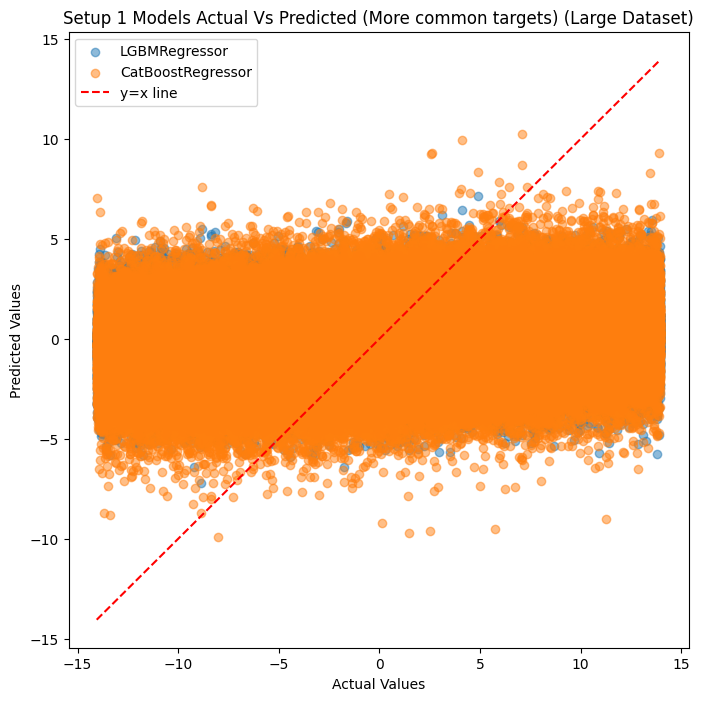

In [21]:
calculate_mae(model_dict_setup1, trained_setup1_models, X_test_large, Y_test_large)
test_scatterplot(trained_setup1_models, X_test_large, Y_test_large, title='Setup 1 Models Actual Vs Predicted (More common targets) (Large Dataset)')

#### Evaluate Error For Model Setup 2 ( (Targets in the Tails of Distribution)

Averaged Prediction MAE: 18.369710424808872
Averaged and Zero Summed Prediction MAE: 18.4817465599542
LGBMRegressor - 3 fold MAE: 18.369710424808872
Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : 18.369710424808872


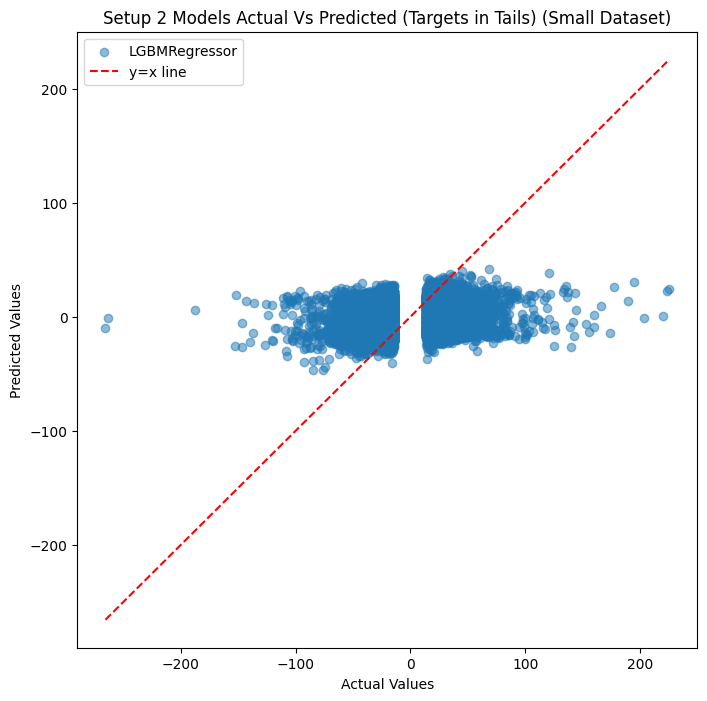

In [16]:
calculate_mae(model_dict_setup2, final_setup2_models, X_test_small, Y_test_small)
test_scatterplot(final_setup2_models, X_test_small, Y_test_small, title='Setup 2 Models Actual Vs Predicted (Targets in Tails) (Small Dataset)')

### What happens if we use the Setup 1's model for more common targets on the outlier model?

Averaged Prediction MAE: 21.38120478093566
Averaged and Zero Summed Prediction MAE: 21.382062624083805
CatBoostRegressor - 3 fold MAE: 21.33462873302887
LGBMRegressor - 3 fold MAE: 21.427780828842458
Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : 21.38120478093566


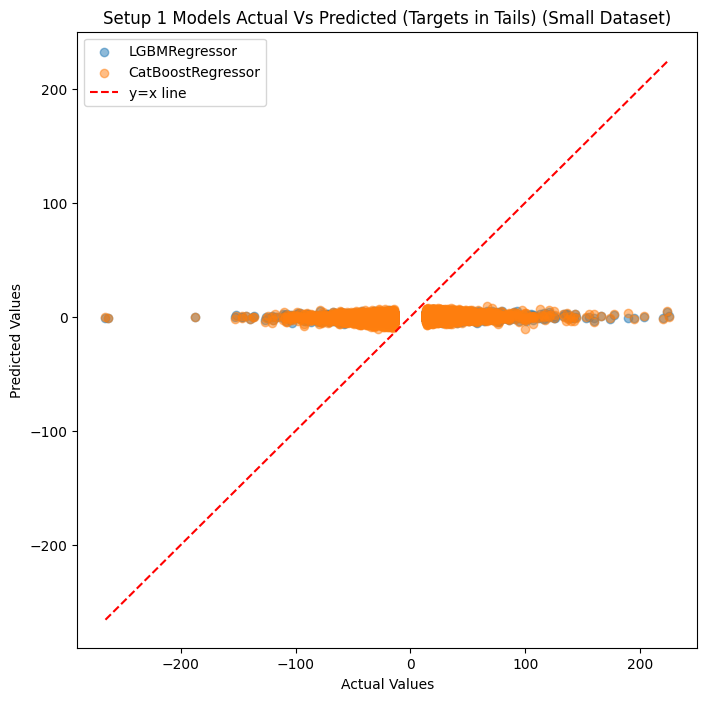

In [58]:
calculate_mae(model_dict_setup1, trained_setup1_models, X_test_small, Y_test_small)
test_scatterplot(trained_setup1_models, X_test_small, Y_test_small, title='Setup 1 Models Actual Vs Predicted (Targets in Tails) (Small Dataset)')

- **We can see that this performs much worse, and our setup 2 is visably better at predicting the outliers. We will continue with the Setup 2 for trying to predict outliers**

## 3. Optimizing Setup 1 and 2 Models
- I will now optimize setup 1 and 2 using randomized search using the smaller datasets

### Optimize Setup 1: (Training/Optimizing on Large Dataset)

In [17]:
%%time
from sklearn.model_selection import RandomizedSearchCV

cbt_param_grid = {
    'learning_rate': [.15, .175, .2, .25],
    'depth': [5, 7, 8, 9, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [300, 400, 500, 600],
  #  'border_count': [32, 64, 128],
  #  'bagging_temperature': [0, 0.5, 1],
  #  'random_strength': [0.5, 1, 2],
  #  'boosting_type': ['Ordered', 'Plain'],
  #  'leaf_estimation_iterations': [1, 5, 10]
}

lgb_param_grid = {
    'learning_rate': [0.125, 0.15, 0.16, 0.18, 0.2],  # More granular learning rates
    'max_depth': [7, 10, 12, 14],
    'num_leaves': [200, 300, 500, 700],  
    'n_estimators': [300, 400, 500],
    'subsample_for_bin': [150000, 200000, 250000, 300000],
    'min_split_gain': [0.15, 0.2, .25, .3],
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
}

# Model instances
cbt_model = cbt.CatBoostRegressor(objective='MAE', early_stopping_rounds=25)
lgb_model = lgb.LGBMRegressor(objective='mae', n_jobs=-1, early_stopping=25)

# Create RandomizedSearchCV instances
cbt_search = RandomizedSearchCV(cbt_model, cbt_param_grid, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=6, cv=3, random_state=42, verbose=2)
lgb_search = RandomizedSearchCV(lgb_model, lgb_param_grid, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=6, cv=3, random_state=42, verbose=2)

# Fit the models with early stopping parameters
cbt_search.fit(X_train_large, Y_train_large, eval_set=[(X_val_large, Y_val_large)], early_stopping_rounds=25, verbose=1)
lgb_search.fit(X_train_large, Y_train_large, eval_metric='mae', eval_set=[(X_val_large, Y_val_large)])

# Retrieve and print the best parameters
print("Best Parameters for Setup 1 CatBoost: ", cbt_search.best_params_)
print("Best Parameters for Setup 1 LightGBM: ", lgb_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 4.6790992	test: 4.6707550	best: 4.6707550 (0)	total: 614ms	remaining: 5m 6s
1:	learn: 4.6674897	test: 4.6593326	best: 4.6593326 (1)	total: 1.18s	remaining: 4m 54s
2:	learn: 4.6589342	test: 4.6509464	best: 4.6509464 (2)	total: 1.83s	remaining: 5m 3s
3:	learn: 4.6521288	test: 4.6442260	best: 4.6442260 (3)	total: 2.45s	remaining: 5m 4s
4:	learn: 4.6466296	test: 4.6389252	best: 4.6389252 (4)	total: 3.01s	remaining: 4m 58s
5:	learn: 4.6424891	test: 4.6349133	best: 4.6349133 (5)	total: 3.63s	remaining: 4m 58s
6:	learn: 4.6389411	test: 4.6315402	best: 4.6315402 (6)	total: 4.19s	remaining: 4m 55s
7:	learn: 4.6362367	test: 4.6289866	best: 4.6289866 (7)	total: 4.84s	remaining: 4m 57s
8:	learn: 4.6333898	test: 4.6263559	best: 4.6263559 (8)	total: 5.46s	remaining: 4m 58s
9:	learn: 4.6315278	test: 4.6245988	best: 4.6245988 (9)	total: 6.01s	remaining: 4m 54s
10:	learn: 4.6295185	test: 4.6226117	best: 4.6226117 (10)	total: 6.58s	r

### Optimize Setup 2: (Training/Optimizing on Small Dataset)

In [18]:
lgb_param_grid = {
    'learning_rate': [0.125, 0.15, 0.16, 0.18, 0.2],  # More granular learning rates
    'max_depth': [7, 10, 12, 14],
    'num_leaves': [200, 300, 500, 700],  
    'n_estimators': [300, 400, 500],
    'subsample_for_bin': [150000, 200000, 250000, 300000],
    'min_split_gain': [0.15, 0.2, .25, .3],
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
}

#Setup 2 Model
lgb_model = lgb.LGBMRegressor(objective='mae', n_jobs=-1, early_stopping=25)

#Randomized search
lgb_search = RandomizedSearchCV(lgb_model, lgb_param_grid, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=6, cv=3, random_state=42, verbose=2)

#Fit the model
lgb_search.fit(X_train_small, Y_train_small, eval_metric='mae', eval_set=[(X_val_small, Y_val_small)])

print("Best Parameters for Setup 2 LightGBM: ", lgb_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] early_stopping_round is set=25, early_stopping=25 will be ignored. Current value: early_stopping_round=25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16975
[LightGBM] [Info] Number of data points in the train set: 418652, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=25, early_stopping=25 will be ignored. Current value: early_stopping_round=25
[LightGBM] [Info] Start training from score -14.060140
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

#### Evaluate Error For Model Setup 1 (Optimized) {5 < target < 95 (percentile)}
- Im just gonna retrain the models cuz they quick and just for consistency


In [19]:
# CBT Parameters (Optimized)
params_cbt = {
    'objective': 'MAE',
    'learning_rate': .15,
    'l2_leaf_reg': 1,
    'iterations': 500,
    'depth': 9,
    'use_best_model': True,
}

# LGBM Parameters (Optimized)
params_lgb = {
    'learning_rate': 0.2,
    'max_depth': 10,
    'n_estimators': 500,
    'num_leaves': 300,
    'objective': 'mae',
    'random_state': 42,
  #  'reg_alpha': 0.01,        leaving out for now
  #  'reg_lambda': 0.01,       leaving out for now
    'n_jobs': -1,
    'early_stopping_rounds': 100,
    'verbose': 2,
    'subsample_for_bin': 250000,
    'min_split_gain': .15,
    'min_child_weight': 1
}

#Had to change names for full so i can analyze on test set its weird its for the model.__name__ part
# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup1 = {
    'CatBoostRegressor': cbt.CatBoostRegressor(**params_cbt),
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup1 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup1"

# Initilaize where I will store all final setup 1 models
trained_setup1_models = []


print('Begin Training/Loading of Setup 1 Models (Optimized)')
for i in range(n_folds):
    trained_setup1_models.append(train_models_with_cv(model_dict_setup1, X_train_large, Y_train_large, X_val_large, Y_val_large, modelname='LGBMRegressor', model_path=model_path_setup1, is_train=True))
    trained_setup1_models.append(train_models_with_cv(model_dict_setup1, X_train_large, Y_train_large, X_val_large, Y_val_large, modelname='CatBoostRegressor', model_path=model_path_setup1, is_train=True))



Begin Training/Loading of Setup 1 Models
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.075683
[LightGBM] [Debug] init for col-wise cost 0.000018 seconds, init for row-wise cost 0.174317 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16969
[LightGBM] [Info] Number of data points in the train set: 2514440, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Debug] Trained a tree with leaves = 300 and depth = 10
Training until validation scores don't improve for 25 rounds
Training until validation scores d

Averaged Prediction MAE: 4.595490330347719
Averaged and Zero Summed Prediction MAE: 4.596058647248846
CatBoostRegressor - 3 fold MAE: 4.5906196455430806
LGBMRegressor - 3 fold MAE: 4.6093134209531605
Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : 4.595490330347719


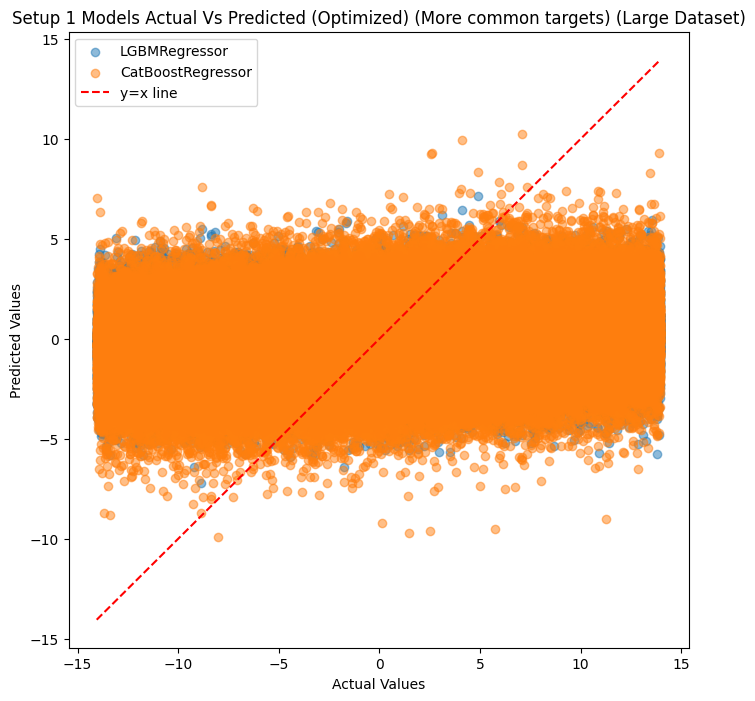

In [20]:
calculate_mae(model_dict_setup1, trained_setup1_models, X_test_large, Y_test_large)
test_scatterplot(trained_setup1_models, X_test_large, Y_test_large, title='Setup 1 Models Actual Vs Predicted (Optimized) (More common targets) (Large Dataset)')

- Look!!!!! The predicitions are becoming more spread out!!! And averaging prevents CatBoost from going too far

#### Evaluate Error For Model Setup 2 (Optimized) (Targets in the Tails of Distribution)

In [22]:
# Initialize the LightGBM regressor (Optimized)
# Leaving out anything I didnt put in cvrandomsearch
lgbm_setup2_params = {
    #'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'num_leaves': 300,  # Use maximum number for 8-depth tree
    'learning_rate': 0.2,   # A smaller learning rate
    'n_estimators': 500,    # More trees
    'max_depth': 10,          # Allowing deep trees
    #'min_child_samples': 20, # Minimum number of data in one leaf
    #'subsample': 0.8,        # Subsample ratio of the training instance
    #'colsample_bytree': 0.8, # Subsample ratio of columns when constructing each tree
    #'reg_alpha': 0.1,        # L1 regularization term on weights 
    #'reg_lambda': 0.1        # L2 regularization term on weights
    'sub_sample_for_bin': 250000,
    'min_split_gain': .15,
    'min_child_weight': 1
}

# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup2 = {
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup2 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup2"

#Initialize Where you will store the final trained Setup2 Models
final_setup2_models = []

#Train Setup 2 Models
print('Begin Training/Loading of Setup 2 Models')
for i in range(n_folds):
    final_setup2_models.append(train_models_with_cv(model_dict_setup2, X_train_small, Y_train_small, X_val_small, Y_val_small, modelname='LGBMRegressor', model_path=model_path_setup2, is_train=True))
   

Begin Training/Loading of Setup 2 Models
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.075106
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.020215 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16975
[LightGBM] [Info] Number of data points in the train set: 279101, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 13.970137
[LightGBM] [Debug] Trained a tree with leaves = 300 and depth = 10
Training until validation scores don't improve for 25 rounds
Training until validation scores do

Averaged Prediction MAE: 18.050221329988346
Averaged and Zero Summed Prediction MAE: 18.08096679677952
LGBMRegressor - 3 fold MAE: 18.05022132998835
Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : 18.050221329988346


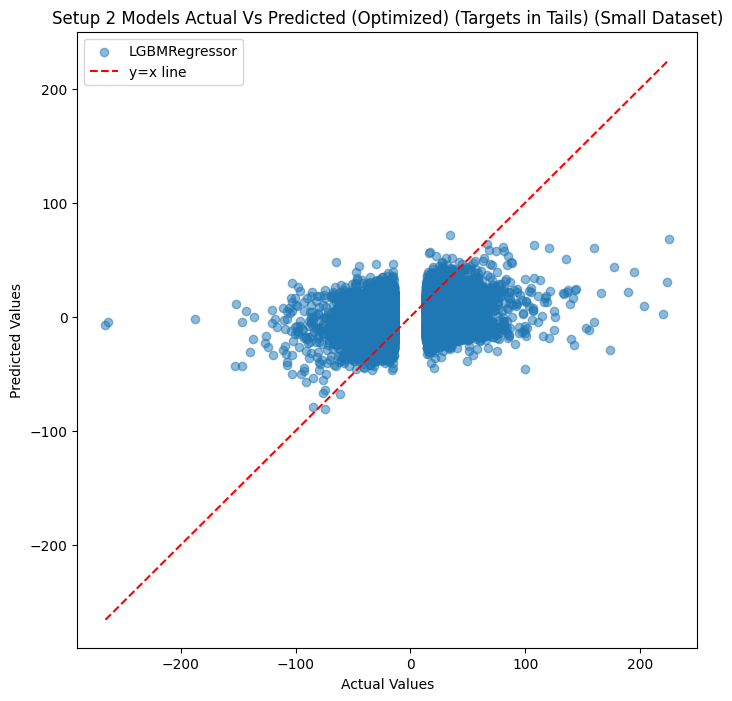

In [23]:
calculate_mae(model_dict_setup2, final_setup2_models, X_test_small, Y_test_small)
test_scatterplot(final_setup2_models, X_test_small, Y_test_small, title='Setup 2 Models Actual Vs Predicted (Optimized) (Targets in Tails) (Small Dataset)')

- Note another decrease in error and they are starting to get closer to predicting the outliers!!! Something none of our models have ever been able to do before. Once again maybe increasing it to the 1% threshold could improve even more!!!!

## 4. Model Setup 3: Training a decision tree, to decide which 'model setup' to use:
I will train a decision tree to predict whether or not the target will be one of the tails or not:
- If this third setup model predicts the target will be in one of the tails, it will then predict using the Setup 2
- If this third setup model predicts the target will not be in one of the tails, it will then predict using Setup 1
**Notes:**
  - This model trains on the FULL training data (normal splitting as above so can test)
- Since I don't know which will work better, I will start off with a basic cbt and basic lgbm. Decide from there which is better and then optimize then.
- After this we will try to start putting all the pieces together
- **1 IS IN THE TAIL 0 IS IF IT IS NOT IN THE TAIL**
- For this case we want a model that is better at predicting if the target will be in the tail

In [24]:
# Note the X, y columns
X = feat_eng(train.drop(columns='target'))
y = train['target'].values

#Create threshold of distribution
lower_threshold = np.percentile(y, 5)
upper_threshold = np.percentile(y, 95)

# Remove rows with missing target values
valid_indices = np.isfinite(y)
X = X[valid_indices]
y = y[valid_indices]

#--------------------------------------------------------------------------------------------------
# Create a binary target: 1 if in the tail, 0 otherwise
y_binary = np.where((y <= lower_threshold) | (y >= upper_threshold), 1, 0)
#--------------------------------------------------------------------------------------------------

# Split the data into training and test
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Save indices
train_index = np.arange(len(X_train))
val_index = np.arange(len(X_val))

Features Finished Calculating


### Model Testing
- CBT worked best so I included only this in the code. i will do the following:
1. Use initial parameters and perform initial error analysis
2. Optimize the Parameters
3. Optimize the cutoff threshold
4. Error Analysis

In [30]:
# Setup the Benchmark Target Classification Model
params_cbt = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'verbose': 10
}

# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup3 = {
    'CatBoostClassifier': cbt.CatBoostClassifier(**params_cbt),
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup3 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup3"

# Initilaize where I will store all final setup 3 models
trained_setup3_models = []

print('Begin Training/Loading of Setup 3 Models (Not Optimized)')
for i in range(n_folds):
    trained_setup3_models.append(train_models_with_cv(model_dict_setup3, X_train, Y_train, X_val, Y_val, modelname='CatBoostClassifier', model_path=model_path_setup3, is_train=True))




Begin Training/Loading of Setup 3 Models (Not Optimized)
0:	learn: 0.5982458	test: 0.5982057	best: 0.5982057 (0)	total: 208ms	remaining: 20.6s
10:	learn: 0.3194669	test: 0.3195252	best: 0.3195252 (10)	total: 2.21s	remaining: 17.9s
20:	learn: 0.2926433	test: 0.2932135	best: 0.2932135 (20)	total: 4.16s	remaining: 15.6s
30:	learn: 0.2871154	test: 0.2879655	best: 0.2879655 (30)	total: 6.33s	remaining: 14.1s
40:	learn: 0.2849698	test: 0.2860662	best: 0.2860662 (40)	total: 8.28s	remaining: 11.9s
50:	learn: 0.2837148	test: 0.2849388	best: 0.2849388 (50)	total: 10.2s	remaining: 9.84s
60:	learn: 0.2827295	test: 0.2840719	best: 0.2840719 (60)	total: 12.3s	remaining: 7.84s
70:	learn: 0.2818373	test: 0.2832893	best: 0.2832893 (70)	total: 14.2s	remaining: 5.81s
80:	learn: 0.2812652	test: 0.2827872	best: 0.2827872 (80)	total: 16.2s	remaining: 3.8s
90:	learn: 0.2805919	test: 0.2821882	best: 0.2821882 (90)	total: 18.2s	remaining: 1.8s
99:	learn: 0.2800690	test: 0.2817070	best: 0.2817070 (99)	total: 20

#### Analyze Initial Classifier Model Error (Setup 3 (Full Dataset))

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Generate predictions from each model
fold_predictions = [model.predict_proba(X_val)[:, 1] for model in trained_setup3_models]

# Average predictions to get final prediction
avg_prediction = np.mean(fold_predictions, axis=0)
# Convert probabilities to binary predictions
final_prediction = np.where(avg_prediction >= 0.5, 1, 0)

# Calculate performance metrics
accuracy = accuracy_score(Y_val, final_prediction)
precision, recall, f1, _ = precision_recall_fscore_support(Y_val, final_prediction, average='binary')
conf_matrix = confusion_matrix(Y_val, final_prediction)

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Display metrics
print("Performance Metrics for Setup 3 Model:")
print(metrics_df)

# Display confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0 (Not In Tail)', 'Predicted 1 (In Tail)'], index=['Actual 0 (Not In Tail)', 'Actual 1 (In Tail)'])
print("\nConfusion Matrix:")
print(conf_matrix_df)

Performance Metrics for Setup 3 Model:
   Accuracy  Precision    Recall  F1 Score
0    0.9007   0.547818  0.022598  0.043405

Confusion Matrix:
                        Predicted 0 (Not In Tail)  Predicted 1 (In Tail)
Actual 0 (Not In Tail)                     470597                    974
Actual 1 (In Tail)                          51038                   1180


#### Optimizing Parameters for Setup 3 Classification Model

In [61]:
#Consider other paraketers later
cbt_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],  # Added smaller learning rates for more granularity
    'depth': [4, 5, 6, 7, 8],  # Made the range a bit tighter to prevent very deep trees which can overfit
    'l2_leaf_reg': [1, 3, 5, 7, 9, 12],  # Expanded the range to include a bit higher regularization
    'iterations': [100, 200, 300, 400, 500],  # Added lower iterations for quicker models and to prevent overfitting
    #'border_count': [32, 64, 128, 254],  # Number of splits for numerical features
    #'scale_pos_weight': [1, (sum(Y_train == 0) / sum(Y_train == 1))],  # To handle class imbalance if it exists
    # Consider adding bootstrap_type and subsample for additional regularization
    #'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    #'subsample': [0.6, 0.7, 0.8, 0.9] if 'bootstrap_type' in ['Bernoulli', 'MVS'] else [None]
}

# Model instances
cbt_model = cbt.CatBoostClassifier(early_stopping_rounds=25, loss_function='Logloss')

# Create RandomizedSearchCV instances
cbt_search = RandomizedSearchCV(cbt_model, cbt_param_grid, n_iter=10, scoring='neg_log_loss', n_jobs=-1, cv=3, random_state=42, verbose=2)

# Fit the models with early stopping parameters
cbt_search.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], early_stopping_rounds=25, verbose=1)

# Retrieve and print the best parameters
print("Best Parameters for Setup 3 CatBoost: ", cbt_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.5209919	test: 0.5209162	best: 0.5209162 (0)	total: 316ms	remaining: 2m 37s
1:	learn: 0.4263735	test: 0.4262158	best: 0.4262158 (1)	total: 669ms	remaining: 2m 46s
2:	learn: 0.3749272	test: 0.3746915	best: 0.3746915 (2)	total: 966ms	remaining: 2m 40s
3:	learn: 0.3419273	test: 0.3417767	best: 0.3417767 (3)	total: 1.33s	remaining: 2m 44s
4:	learn: 0.3233532	test: 0.3231988	best: 0.3231988 (4)	total: 1.62s	remaining: 2m 40s
5:	learn: 0.3104633	test: 0.3103682	best: 0.3103682 (5)	total: 1.98s	remaining: 2m 42s
6:	learn: 0.3038436	test: 0.3037597	best: 0.3037597 (6)	total: 2.3s	remaining: 2m 41s
7:	learn: 0.2991052	test: 0.2990690	best: 0.2990690 (7)	total: 2.65s	remaining: 2m 42s
8:	learn: 0.2959555	test: 0.2959470	best: 0.2959470 (8)	total: 2.97s	remaining: 2m 42s
9:	learn: 0.2935458	test: 0.2936020	best: 0.2936020 (9)	total: 3.35s	remaining: 2m 44s
10:	learn: 0.2920436	test: 0.2921105	best: 0.2921105 (10)	total: 3.67s

#### Initialize Setup 3 Optimized Model
- This model has the optimized parameters for Setup 3

In [64]:
# Setup the Benchmark Target Classification Model
params_cbt = {
    'iterations': 500,
    'learning_rate': 0.2,
    'depth': 5,
    'l2_leaf_reg': 12,
    'loss_function': 'Logloss',
    'verbose': 10
}

# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup3 = {
    'CatBoostClassifier': cbt.CatBoostClassifier(**params_cbt),
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup3 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup3"

# Initilaize where I will store all final setup 3 models
trained_setup3_models = []

print('Begin Training/Loading of Setup 3 Models (Optimized)')
for i in range(n_folds):
    trained_setup3_models.append(train_models_with_cv(model_dict_setup3, X_train, Y_train, X_val, Y_val, modelname='CatBoostClassifier', model_path=model_path_setup3, is_train=True))


Begin Training/Loading of Setup 3 Models (Optimized)
0:	learn: 0.5212109	test: 0.5210698	best: 0.5210698 (0)	total: 168ms	remaining: 1m 23s
10:	learn: 0.2927371	test: 0.2930471	best: 0.2930471 (10)	total: 1.89s	remaining: 1m 23s
20:	learn: 0.2861443	test: 0.2869474	best: 0.2869474 (20)	total: 3.6s	remaining: 1m 22s
30:	learn: 0.2839158	test: 0.2850216	best: 0.2850216 (30)	total: 5.3s	remaining: 1m 20s
40:	learn: 0.2823161	test: 0.2835978	best: 0.2835978 (40)	total: 7.03s	remaining: 1m 18s
50:	learn: 0.2811170	test: 0.2825031	best: 0.2825031 (50)	total: 8.79s	remaining: 1m 17s
60:	learn: 0.2805319	test: 0.2820182	best: 0.2820182 (60)	total: 10.5s	remaining: 1m 15s
70:	learn: 0.2799255	test: 0.2814825	best: 0.2814825 (70)	total: 12.2s	remaining: 1m 13s
80:	learn: 0.2792899	test: 0.2809208	best: 0.2809208 (80)	total: 13.9s	remaining: 1m 12s
90:	learn: 0.2787516	test: 0.2804041	best: 0.2804041 (90)	total: 15.7s	remaining: 1m 10s
100:	learn: 0.2780987	test: 0.2797777	best: 0.2797777 (100)	t

#### Analyze Error for Optimized Model

In [65]:
# Generate predictions from each model
fold_predictions = [model.predict_proba(X_val)[:, 1] for model in trained_setup3_models]

# Average predictions to get final prediction
avg_prediction = np.mean(fold_predictions, axis=0)
# Convert probabilities to binary predictions
final_prediction = np.where(avg_prediction >= 0.5, 1, 0)

# Calculate performance metrics
accuracy = accuracy_score(Y_val, final_prediction)
precision, recall, f1, _ = precision_recall_fscore_support(Y_val, final_prediction, average='binary')
conf_matrix = confusion_matrix(Y_val, final_prediction)

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Display metrics
print("Performance Metrics for Setup 3 Model:")
print(metrics_df)

# Display confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0 (Not In Tail)', 'Predicted 1 (In Tail)'], index=['Actual 0 (Not In Tail)', 'Actual 1 (In Tail)'])
print("\nConfusion Matrix:")
print(conf_matrix_df)

Performance Metrics for Setup 3 Model:
   Accuracy  Precision    Recall  F1 Score
0  0.901185    0.55999  0.041116  0.076607

Confusion Matrix:
                        Predicted 0 (Not In Tail)  Predicted 1 (In Tail)
Actual 0 (Not In Tail)                     469884                   1687
Actual 1 (In Tail)                          50071                   2147


#### Optimizing the cutoff threshold on the model
- To find the optimal threshold for your classification model, you'll typically want to maximize some performance metric like the F1 score or the area under the receiver operating characteristic (ROC) curve, which balances both precision and recall.

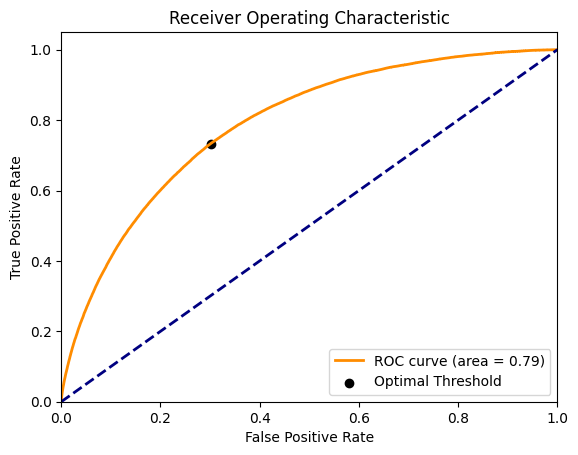

Optimal threshold: 0.10012900668527576


In [66]:
from sklearn.metrics import roc_curve, roc_auc_score

# Generate probabilities for the positive class (assuming class 1 is the positive class)
fold_probabilities = [model.predict_proba(X_val)[:, 1] for model in trained_setup3_models]
avg_probabilities = np.mean(fold_probabilities, axis=0)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_val, avg_probabilities)

# Calculate the AUC
roc_auc = roc_auc_score(Y_val, avg_probabilities)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'Optimal threshold: {optimal_threshold}')

- We Will use this threshold and note any improvement


In [67]:
# Generate predictions from each model
fold_predictions = [model.predict_proba(X_val)[:, 1] for model in trained_setup3_models]

# Average predictions to get final prediction
avg_prediction = np.mean(fold_predictions, axis=0)

# Convert probabilities to binary predictions (USING OPTIMIZED THRESHOLD)
final_prediction = np.where(avg_prediction >= 0.10, 1, 0)

# Calculate performance metrics
accuracy = accuracy_score(Y_val, final_prediction)
precision, recall, f1, _ = precision_recall_fscore_support(Y_val, final_prediction, average='binary')
conf_matrix = confusion_matrix(Y_val, final_prediction)

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Display metrics
print("Performance Metrics for Setup 3 Model (Optimized Threshold) (Non-Optimized Parameters):")
print(metrics_df)

# Display confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0 (Not In Tail)', 'Predicted 1 (In Tail)'], index=['Actual 0 (Not In Tail)', 'Actual 1 (In Tail)'])
print("\nConfusion Matrix:")
print(conf_matrix_df)

Performance Metrics for Setup 3 Model (Optimized Threshold) (Non-Optimized Parameters):
   Accuracy  Precision   Recall  F1 Score
0  0.702124   0.212312  0.73354   0.32931

Confusion Matrix:
                        Predicted 0 (Not In Tail)  Predicted 1 (In Tail)
Actual 0 (Not In Tail)                     329461                 142110
Actual 1 (In Tail)                          13914                  38304


- **This threshold sacrifices too many predictions True Positives in the tails, will investigate further**

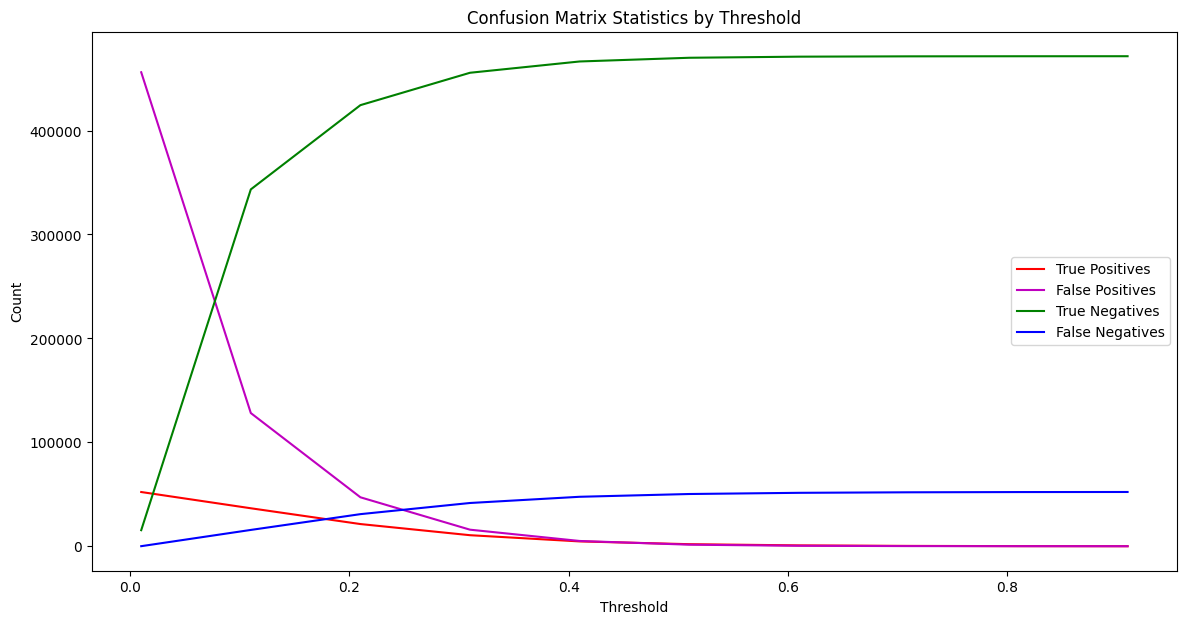

In [68]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(Y_val, avg_prediction)

# Function to calculate confusion matrix at a given threshold
def calculate_confusion_matrix(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp, fp, tn, fn

# Calculate confusion matrix for thresholds from 0.01 to 0.95 in increments of 0.05
thresholds_to_test = np.arange(0.01, 0.95, 0.1)
conf_matrix_values = [calculate_confusion_matrix(Y_val, avg_prediction, thr) for thr in thresholds_to_test]

# Convert the list of tuples to a DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_values, columns=['TP', 'FP', 'TN', 'FN'])

# Plotting the True Positives, False Positives, True Negatives, and False Negatives against the thresholds
plt.figure(figsize=(14, 7))
plt.plot(thresholds_to_test, conf_matrix_df['TP'], 'r-', label='True Positives')
plt.plot(thresholds_to_test, conf_matrix_df['FP'], 'm-', label='False Positives')
plt.plot(thresholds_to_test, conf_matrix_df['TN'], 'g-', label='True Negatives')
plt.plot(thresholds_to_test, conf_matrix_df['FN'], 'b-', label='False Negatives')

plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('Confusion Matrix Statistics by Threshold')
plt.legend(loc='best')
plt.show()


- From this chart I really like the threshold somewhere between .2 - .6. I want to maximize the True Negatives (Not in tails) but be able to identify as many True Positives as I can. Basically I'm looking for a good trade off, and I have already ran that threshold function based on ROC. However, I would still prefer the highest number of True Negatives as possible. Therefore maybe chaning what the tails thresholds are could help with this.

### Side Quest: Investing the target a bit more by quantile